# Analyse de données sur les Jeux Olympiques

Guillaume - Eva- Amaury

##  1) le dataset 

Notre dataset est un double jeu de données concernant les Jeux Olympiques.

Il se structure en deux fichiers .csv.

## 1.1) Premier fichier : les NOCs

Correspond aux commités olympiques nationaux, codifiés en trois lettres. Chaque équipe relève d'un NOC lié généralement à un pays (région).

**Contient 230 entrées.**

## 1.2) Deuxième fichier : les athlètes :

Contient tout le reste des infos agrégées autour d'athlètes ayant leur identifiant. On retrouve les caractéristiques des athlètes, leurs médailles, les épreuves, les jeux, etc.

**Contient 271 116 entrées !**

## 2) Nettoyage des données 

Nous avons procédé à certaines vérifications sur nos datasets .csv via Excel.

### 2.1) Vérification du fait que chaque NOC de team dans le dataset principal avait une contrepartie en table NOC :

On effectue la formule suivante pour toutes les lignes puis on filtre :

= RECHERCHEV( G1 ; A:A; 1; 0)

**Conclusion :** rares cas de Singapour (SGP) où ce n’était pas bon. Création manuelle d’un NOC SGP pour Singapour dans la table nocs. 

### 2.2) Vérification que les id des athlètes présents dans le dataset .csv principal correspondaient tous à un athlète unique.

C’est-à-dire qu’il n’y ait pas un cas où les ids étaient le même mais où les noms seraient différents. Si c'était bon à ce niveau on pouvait ré-utiliser les ID du dataset pour créer ceux de notre database.

On utilise la formule suivante (B3 et B2 sont des noms successifs dont on compare l’identité et A2 et A3 sont des id). Grâce au ET on recherche le cas où deux noms successifs sont différents alors que les id seraient le même.

=ET(SI(B3<>B2;1;0);SI(A2=A3;1;0))

**Conclusion :** la recherche renvoie FAUX dans tous les cas. Cela veut dire que nos id correspondent bien à des athlètes uniques et on peut donc directement les utiliser pour remplir la colonne id_athlete de la table athletes en base.

### 2.3) Problème de cas particuliers sur les dates : une édition des JO a eu lieu en 1896 ! C’est trop vieux et inférieur à la borne gauche du datatype YEAR de SQL qui va de 1901 à 2155 (un byte).
Solution : passage sur un type SMALLINT qui fera l’affaire jusqu’aux JO de l’an 32 767.

### 2.4) Remplissage des valeurs manquantes pour éviter les problèmes lors des injections SQL :
-Poids , tailles et âges manquants => Remplacement par la médiane, moins sensible aux valeurs extrêmes que la moyenne.

## 3) La Database MySQL

### 3.1) Le MCD

Objectif pouvoir accéder facilement aux données, ne rien omettre et permettre des requêtes SQL pas trop compliquées malgré tout.

**Idée :** une relation d'association centrale (qui donnera une table intermédiaire) qui relie tout ensemble par la relation entre un athlète donné et une épreuve sportive donnée.

<img src = "https://i.ibb.co/yhX6XHb/MCD.jpg" title = "MCD" alt = "MCD">

### 3.2) Vue d'ensemble de notre BDD

<img src = "https://i.ibb.co/KmYBbkj/image.png" title = "MCD" alt = "MCD">


### 3.3) Vues et procédures 

Médailles d'or remportées pour un NOC donné :

<img src = "https://i.ibb.co/cTZFLp4/image.png" title = "Vue" alt = "Vue">


### 3.4) Les insertions SQL en base via Python

Une fois les données suffisamment nettoyées, nous avons utilisé un **connecteur mySQL python** et réalisé un programme qui procède aux injections dans les tables.

L'idée est de récupérer les dataframe series par colonnes qu'on souhaite injecter, passer ces dataype pandas en liste de listes puis en listes de tuples. Ensuite, le tout est passé curseur mySQL Python.

**Petit bonus :** pour gérer la taille maximale de paquets (limite en MB que MySQL peut tolérer), nous avons modifié un script de Binomotron afin de créer une fonction qui découpe nos listes de tuples pour injection en plus petites listes.

Il suffit de rentrer un pourcentage et la fonction *slicer* découpe la liste en bouts que MySQL va pouvoir plus facilement avaler avec la méthode curseur.executemany().

Exemple : découper la liste de tuples villes en listes faisant 10% de taille : 
```
liste_villes = slicer(liste_villes, 0.01)
```

Une autre solution que nous n'avons pas explorée car la nôtre fonctionnait était d'augmenter manuellement la limite du *max_allowed_packet* de MySQL.


## 4) Analyse des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("archive/athlete_events.csv")
df2 = pd.read_csv("archive/noc_regions.csv")
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [3]:
df.describe()

,ID,Age,Height,Weight,Year
count,271116.000000,261642.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.393561,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


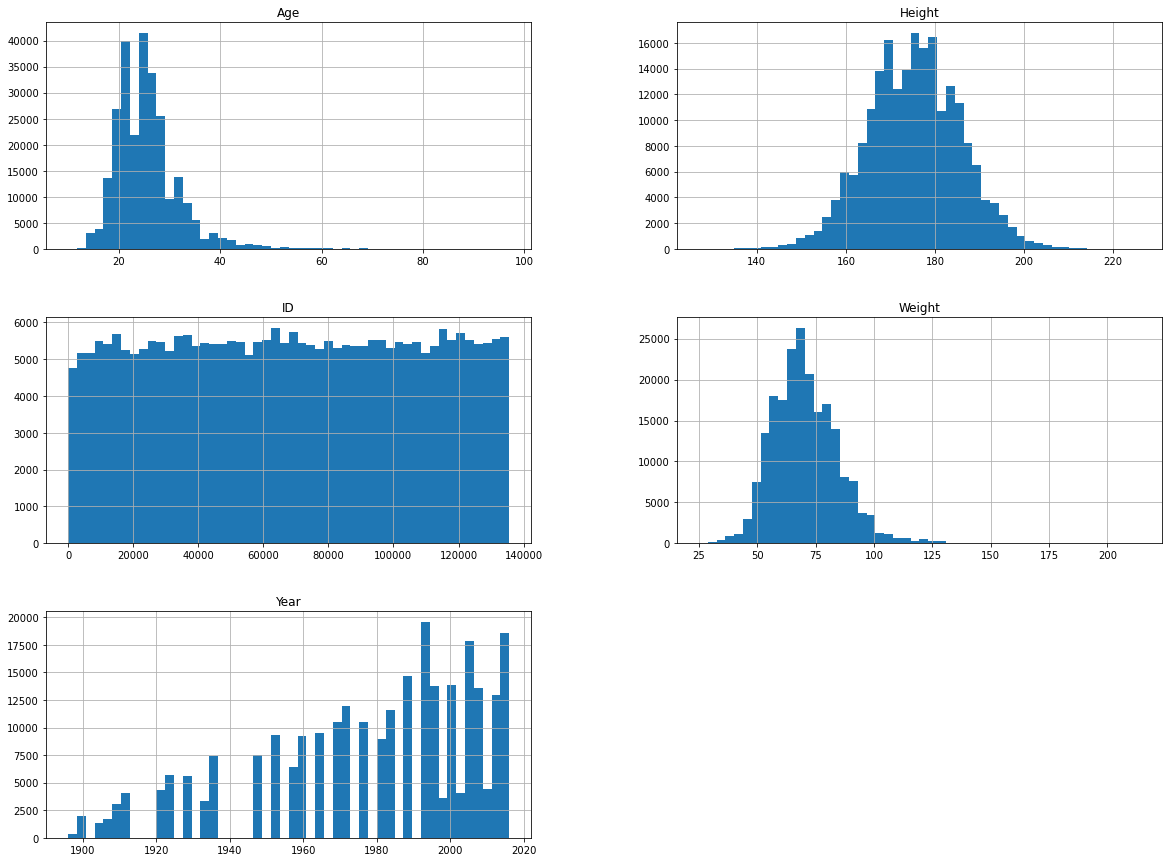

In [4]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
merged = pd.merge(df, df2, on='NOC', how="left")
merged.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN


In [6]:
goldMedals = merged[(merged["Medal"] == "Gold")]
goldMedals.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
42,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Team All-Around,Gold,Finland,NaN
44,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Horse Vault,Gold,Finland,NaN
48,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Pommelled Horse,Gold,Finland,NaN
60,20,Kjetil Andr Aamodt,M,20.0,176.0,85.0,Norway,NOR,1992 Winter,1992,Winter,Albertville,Alpine Skiing,Alpine Skiing Men's Super G,Gold,Norway,NaN


In [7]:
goldMedals.isnull().any()

ID        False
Name      False
Sex       False
Age        True
Height     True
Weight     True
Team      False
NOC       False
Games     False
Year      False
Season    False
City      False
Sport     False
Event     False
Medal     False
region     True
notes      True
dtype: bool

In [103]:
df.corr()

,ID,Age,Height,Weight,Year
ID,1.000000,-0.003631,-0.011141,-0.009176,0.011885
Age,-0.003631,1.000000,0.138246,0.212069,-0.115137
Height,-0.011141,0.138246,1.000000,0.796213,0.047578
Weight,-0.009176,0.212069,0.796213,1.000000,0.019095
Year,0.011885,-0.115137,0.047578,0.019095,1.000000


In [8]:
goldMedals = goldMedals[np.isfinite(goldMedals["Age"])]

Text(0.5, 1.0, 'Distribution of Gold Medals')

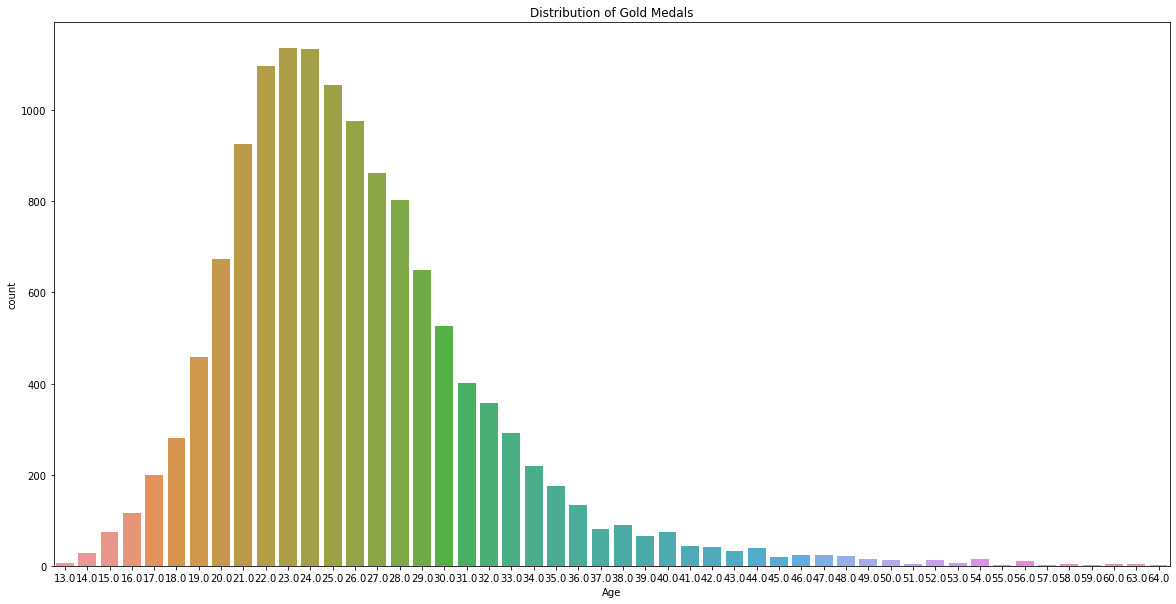

In [9]:
plt.figure(figsize=(20, 10))
plt.tight_layout()
sns.countplot(goldMedals['Age'])
plt.title('Distribution of Gold Medals')

In [10]:
masterDisciplines = goldMedals['Sport'][goldMedals['Age'] > 50]

Text(0.5, 1.0, 'Gold Medals for Athletes Over 50')

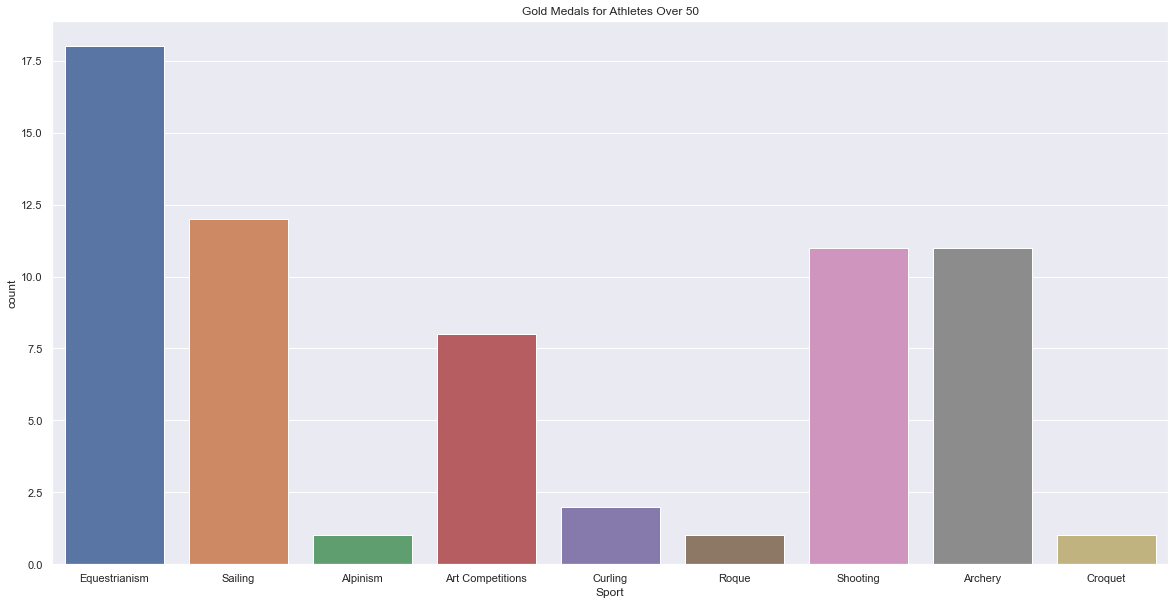

In [82]:
plt.figure(figsize=(20, 10))
plt.tight_layout()
sns.countplot(masterDisciplines)
plt.title('Gold Medals for Athletes Over 50')

In [90]:
juniorDisciplines = goldMedals["Sport"][goldMedals['Age'] < 16]
#juniorDisciplines["Sport"].value_counts()
#juniorDisciplines = juniorDisciplines["Sport"].value_counts()

Text(0.5, 1.0, 'Gold Medals for Athletes Over 50')

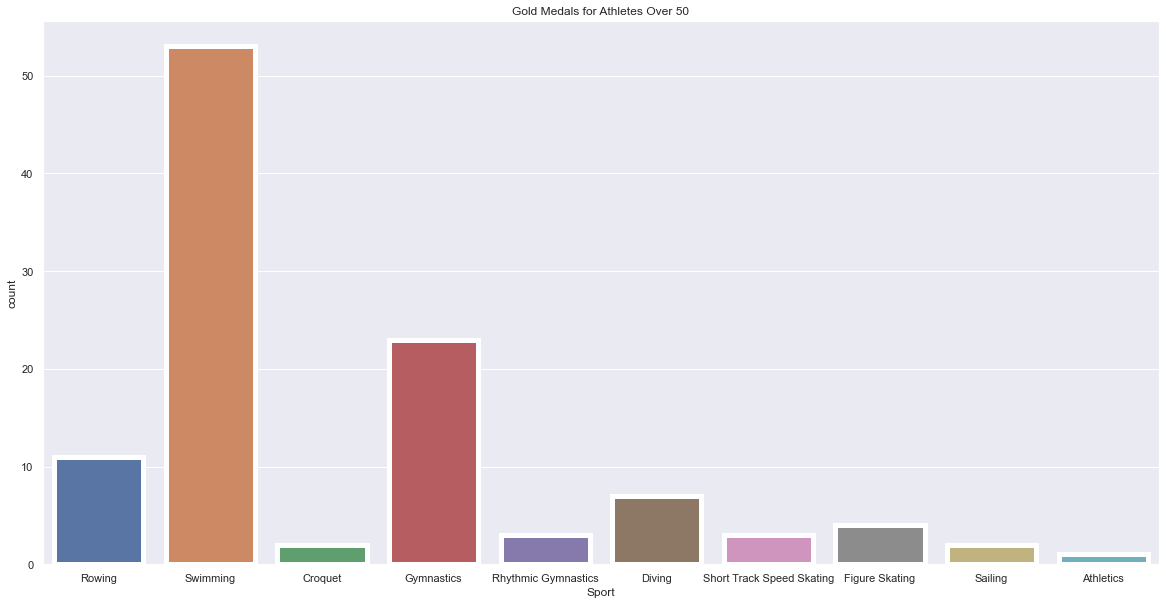

In [97]:
plt.figure(figsize=(20, 10))
plt.tight_layout()
sns.countplot(juniorDisciplines, linewidth=5)
plt.title('Gold Medals for Athletes Over 50')

In [13]:
womenInOlympics = merged[(merged.Sex == 'F') & (merged.Season == 'Summer')]
womenInOlympics.head(10)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
26,8,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.0,NaN,Netherlands,NED,1932 Summer,1932,Summer,Los Angeles,Athletics,Athletics Women's 100 metres,NaN,Netherlands,NaN
27,8,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.0,NaN,Netherlands,NED,1932 Summer,1932,Summer,Los Angeles,Athletics,Athletics Women's 4 x 100 metres Relay,NaN,Netherlands,NaN
32,13,Minna Maarit Aalto,F,30.0,159.0,55.5,Finland,FIN,1996 Summer,1996,Summer,Atlanta,Sailing,Sailing Women's Windsurfer,NaN,Finland,NaN
33,13,Minna Maarit Aalto,F,34.0,159.0,55.5,Finland,FIN,2000 Summer,2000,Summer,Sydney,Sailing,Sailing Women's Windsurfer,NaN,Finland,NaN
79,21,Ragnhild Margrethe Aamodt,F,27.0,163.0,NaN,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold,Norway,NaN
80,22,Andreea Aanei,F,22.0,170.0,125.0,Romania,ROU,2016 Summer,2016,Summer,Rio de Janeiro,Weightlifting,Weightlifting Women's Super-Heavyweight,NaN,Romania,NaN
91,29,Willemien Aardenburg,F,22.0,NaN,NaN,Netherlands,NED,1988 Summer,1988,Summer,Seoul,Hockey,Hockey Women's Hockey,Bronze,Netherlands,NaN
105,37,Ann Kristin Aarnes,F,23.0,182.0,64.0,Norway,NOR,1996 Summer,1996,Summer,Atlanta,Football,Football Women's Football,Bronze,Norway,NaN
135,49,Moonika Aava,F,24.0,168.0,65.0,Estonia,EST,2004 Summer,2004,Summer,Athina,Athletics,Athletics Women's Javelin Throw,NaN,Estonia,NaN
136,49,Moonika Aava,F,28.0,168.0,65.0,Estonia,EST,2008 Summer,2008,Summer,Beijing,Athletics,Athletics Women's Javelin Throw,NaN,Estonia,NaN


Text(0.5, 1.0, 'Women medals per edition of the Games')

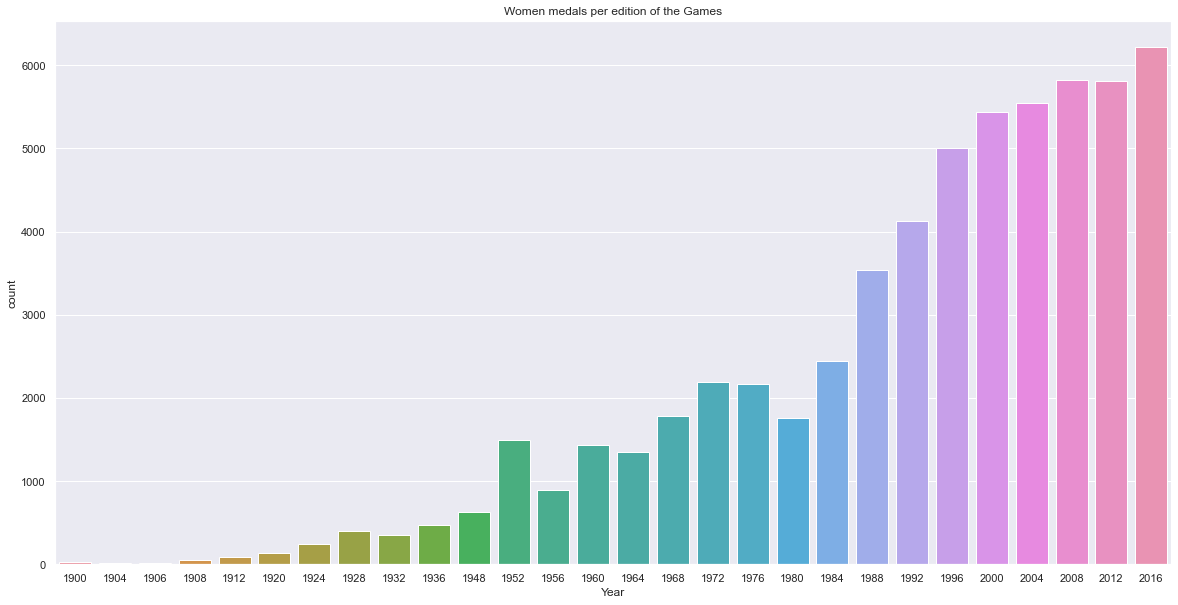

In [14]:
sns.set(style="darkgrid")
plt.figure(figsize=(20, 10))
sns.countplot(x='Year', data=womenInOlympics)
plt.title('Women medals per edition of the Games')

In [15]:
totalGoldMedals = goldMedals.region.value_counts().reset_index(name='Medal').head(5)

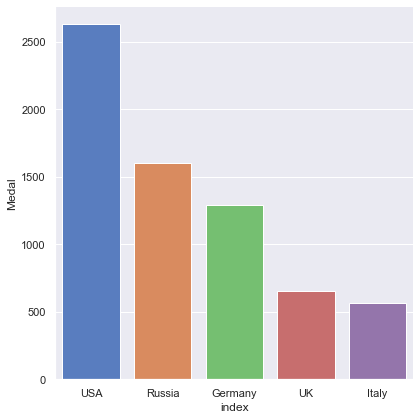

In [16]:
g = sns.catplot(x="index", y="Medal", data=totalGoldMedals,
                height=6, kind="bar", palette="muted")

Text(0.5, 1.0, 'Age vs. Height')

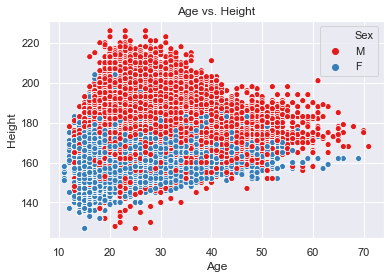

In [99]:
sns.scatterplot(x='Age', y='Height', hue='Sex', data=df, palette='Set1')
plt.title('Age vs. Height')

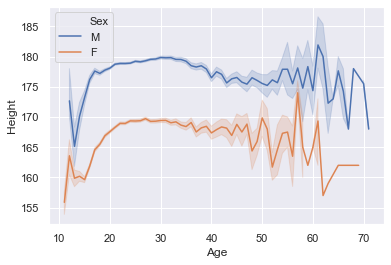

In [100]:
sns.lineplot(x='Age', y='Height', data=df, hue='Sex')

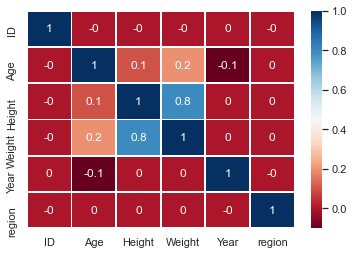

In [175]:
corr = merged.corr().round(1)
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,cmap='RdBu', annot=True, linewidth=0.7)